In [22]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GaussianNoise
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [35]:
def load_data(file_path, normal_person='p1', abnormal_person='p2'):
    # CSV 파일 읽기
    df = pd.read_csv(file_path)
    print("\n데이터셋 정보:")
    print(df['people'].value_counts())
    
    # 데이터 분리
    normal_data = df[df['people'] == normal_person]
    abnormal_data = df[df['people'] == abnormal_person]
    
    print(f"\n정상 데이터 (Person {normal_person}) 형태:", normal_data.shape)
    print(f"비정상 데이터 (Person {abnormal_person}) 형태:", abnormal_data.shape)
    
    # 문자열 열 제거 또는 변환
    numeric_columns = normal_data.select_dtypes(include=[np.number]).columns
    
    # 숫자형 데이터만 선택
    normal_data = normal_data[numeric_columns]
    abnormal_data = abnormal_data[numeric_columns]
    
    print("\n숫자형 특성만 선택 후 데이터 형태:")
    print("정상 데이터:", normal_data.shape)
    print("비정상 데이터:", abnormal_data.shape)
    
    # 데이터 정규화
    scaler = StandardScaler()
    normal_data_scaled = scaler.fit_transform(normal_data)
    abnormal_data_scaled = scaler.transform(abnormal_data)
    
    return normal_data_scaled, abnormal_data_scaled

In [36]:
# 대칭형 오토인코더
def build_symmetric_autoencoder(input_dim):
    input_layer = Input(shape=(input_dim,))
    
    # Encoder
    encoded = Dense(128, activation='relu')(input_layer)
    encoded = Dense(64, activation='relu')(encoded)
    encoded = Dense(32, activation='relu')(encoded)
    
    # Decoder
    decoded = Dense(64, activation='relu')(encoded)
    decoded = Dense(128, activation='relu')(decoded)
    decoded = Dense(input_dim, activation='linear')(decoded)
    
    return Model(input_layer, decoded)

In [37]:
# 비대칭형 오토인코더
def build_asymmetric_autoencoder(input_dim):
    input_layer = Input(shape=(input_dim,))
    
    # Encoder (더 적은 뉴런)
    encoded = Dense(64, activation='relu')(input_layer)
    encoded = Dense(32, activation='relu')(encoded)
    encoded = Dense(16, activation='relu')(encoded)
    
    # Decoder (더 많은 뉴런)
    decoded = Dense(32, activation='relu')(encoded)
    decoded = Dense(128, activation='relu')(decoded)
    decoded = Dense(256, activation='relu')(decoded)
    decoded = Dense(input_dim, activation='linear')(decoded)
    
    return Model(input_layer, decoded)

In [38]:
# DAE (Denoising Autoencoder)
def build_denoising_autoencoder(input_dim, noise_factor=0.1):
    input_layer = Input(shape=(input_dim,))
    
    # 노이즈 추가
    noise = GaussianNoise(noise_factor)(input_layer)
    
    # Encoder
    encoded = Dense(128, activation='relu')(noise)
    encoded = Dense(64, activation='relu')(encoded)
    encoded = Dense(32, activation='relu')(encoded)
    
    # Decoder
    decoded = Dense(64, activation='relu')(encoded)
    decoded = Dense(128, activation='relu')(decoded)
    decoded = Dense(input_dim, activation='linear')(decoded)
    
    return Model(input_layer, decoded)

In [39]:
# 모델 학습 및 평가 함수
def train_and_evaluate(model, normal_data, abnormal_data, model_name):
    # 데이터 분할
    X_train, X_val = train_test_split(normal_data, test_size=0.2, random_state=42)
    
    # 모델 컴파일
    model.compile(optimizer='adam', loss='mse')
    
    # 모델 학습
    history = model.fit(
        X_train, X_train,
        epochs=50,
        batch_size=32,
        validation_data=(X_val, X_val),
        verbose=1
    )
    
    # 재구성 오차 계산
    normal_pred = model.predict(normal_data)
    abnormal_pred = model.predict(abnormal_data)
    
    normal_errors = np.mean(np.power(normal_data - normal_pred, 2), axis=1)
    abnormal_errors = np.mean(np.power(abnormal_data - abnormal_pred, 2), axis=1)
    
    # 결과 시각화
    plt.figure(figsize=(10, 6))
    plt.hist(normal_errors, bins=50, alpha=0.5, label=f'Normal (Person {normal_person})')
    plt.hist(abnormal_errors, bins=50, alpha=0.5, label=f'Abnormal (Person {abnormal_person})')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Count')
    plt.title(f'Reconstruction Error Distribution - {model_name}')
    plt.legend()
    plt.show()
    
    # 성능 평가
    threshold = np.percentile(normal_errors, 95)
    false_positive_rate = np.mean(normal_errors > threshold)
    detection_rate = np.mean(abnormal_errors > threshold)
    
    print(f"\n{model_name} 성능:")
    print(f"임계값: {threshold:.6f}")
    print(f"정상 데이터 오탐율: {false_positive_rate:.3f}")
    print(f"비정상 데이터 탐지율: {detection_rate:.3f}")
    
    return history


데이터셋 정보:
people
p1    1140
p2    1140
p3    1140
p4    1140
p5    1140
p6    1140
p7    1140
p8    1140
Name: count, dtype: int64

정상 데이터 (Person p1) 형태: (1140, 272)
비정상 데이터 (Person p2) 형태: (1140, 272)

숫자형 특성만 선택 후 데이터 형태:
정상 데이터: (1140, 270)
비정상 데이터: (1140, 270)

입력 차원: 270
Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9344 - val_loss: 0.5888
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5722 - val_loss: 0.4249
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4008 - val_loss: 0.3446
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3359 - val_loss: 0.3059
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2997 - val_loss: 0.2815
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3048 - val_loss: 0.2660
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2575 - val_loss: 0.2542
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2507 - val_loss: 0.2479
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

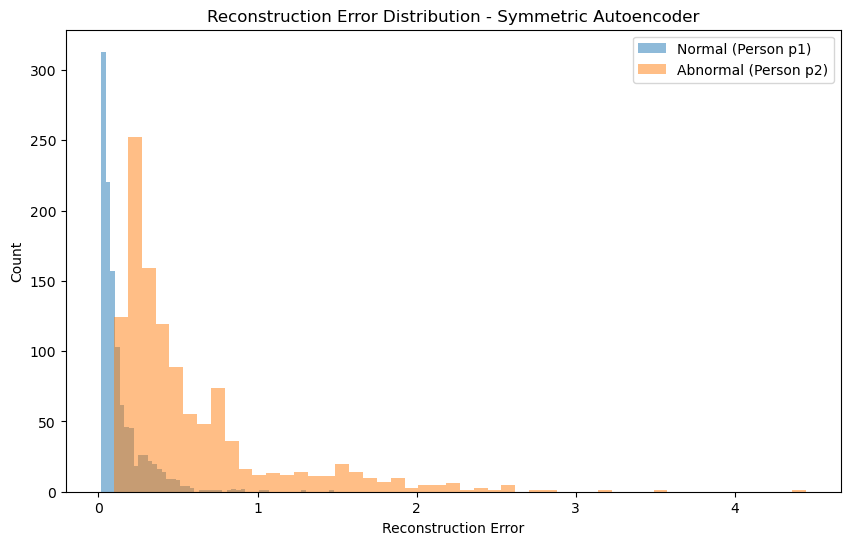


Symmetric Autoencoder 성능:
임계값: 0.415751
정상 데이터 오탐율: 0.050
비정상 데이터 탐지율: 0.461
Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 1.0051 - val_loss: 0.5917
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6013 - val_loss: 0.4349
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4396 - val_loss: 0.3690
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4178 - val_loss: 0.3224
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3302 - val_loss: 0.2904
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3021 - val_loss: 0.2724
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3084 - val_loss: 0.2616
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2601 - val_loss: 0.2527
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2562 - val_loss: 0.2462
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2509 - val_loss: 0.2415
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2470 - val_loss: 0.

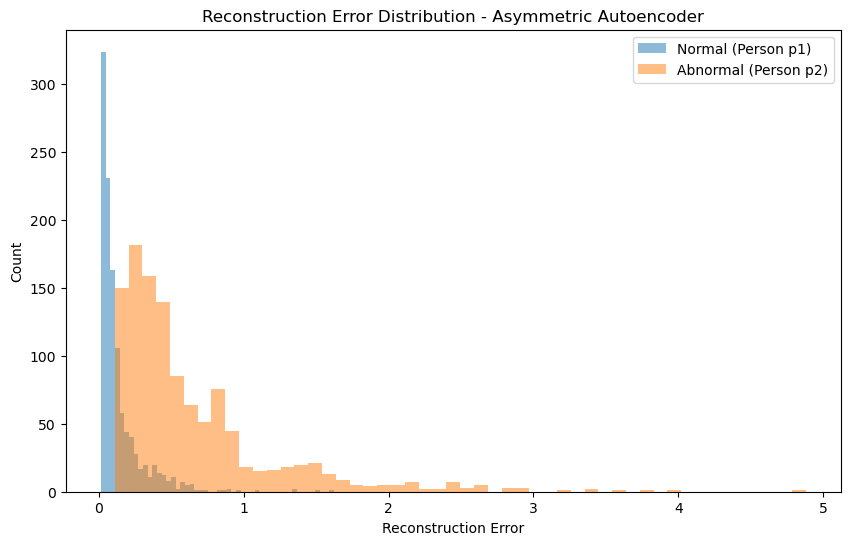


Asymmetric Autoencoder 성능:
임계값: 0.447030
정상 데이터 오탐율: 0.050
비정상 데이터 탐지율: 0.501
Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.9528 - val_loss: 0.6513
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6178 - val_loss: 0.4424
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4030 - val_loss: 0.3512
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3566 - val_loss: 0.3029
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3144 - val_loss: 0.2761
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2779 - val_loss: 0.2614
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2645 - val_loss: 0.2484
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2223 - val_loss: 0.2422
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2301 - val_loss: 0.2370
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2191 - val_loss: 0.2292
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2119 - val_loss: 0

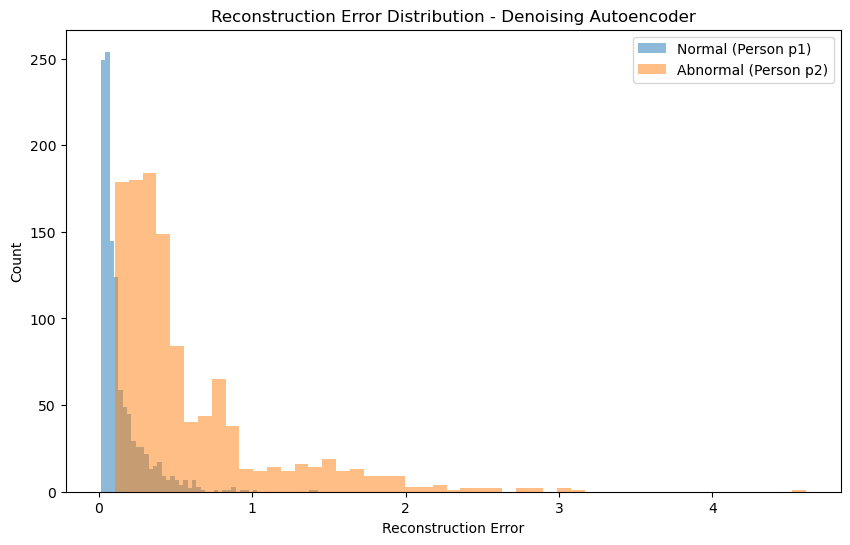


Denoising Autoencoder 성능:
임계값: 0.444107
정상 데이터 오탐율: 0.050
비정상 데이터 탐지율: 0.430


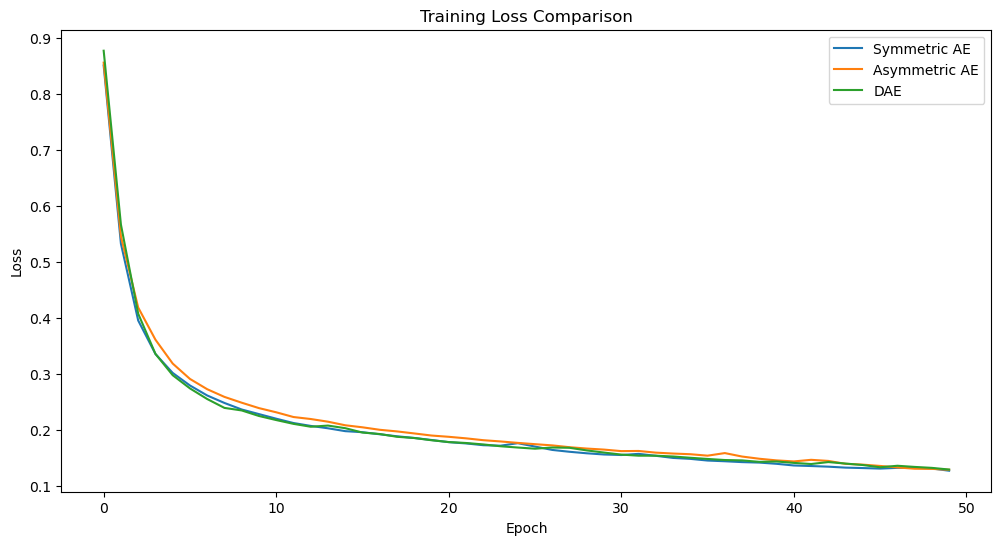

In [41]:
def train_and_evaluate(model, normal_data, abnormal_data, model_name, normal_person, abnormal_person):
    # 데이터 분할
    X_train, X_val = train_test_split(normal_data, test_size=0.2, random_state=42)
    
    # 모델 컴파일
    model.compile(optimizer='adam', loss='mse')
    
    # 모델 학습
    history = model.fit(
        X_train, X_train,
        epochs=50,
        batch_size=32,
        validation_data=(X_val, X_val),
        verbose=1
    )
    
    # 재구성 오차 계산
    normal_pred = model.predict(normal_data)
    abnormal_pred = model.predict(abnormal_data)
    
    normal_errors = np.mean(np.power(normal_data - normal_pred, 2), axis=1)
    abnormal_errors = np.mean(np.power(abnormal_data - abnormal_pred, 2), axis=1)
    
    # 결과 시각화
    plt.figure(figsize=(10, 6))
    plt.hist(normal_errors, bins=50, alpha=0.5, label=f'Normal (Person {normal_person})')
    plt.hist(abnormal_errors, bins=50, alpha=0.5, label=f'Abnormal (Person {abnormal_person})')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Count')
    plt.title(f'Reconstruction Error Distribution - {model_name}')
    plt.legend()
    plt.show()
    
    # 성능 평가
    threshold = np.percentile(normal_errors, 95)
    false_positive_rate = np.mean(normal_errors > threshold)
    detection_rate = np.mean(abnormal_errors > threshold)
    
    print(f"\n{model_name} 성능:")
    print(f"임계값: {threshold:.6f}")
    print(f"정상 데이터 오탐율: {false_positive_rate:.3f}")
    print(f"비정상 데이터 탐지율: {detection_rate:.3f}")
    
    return history

def main():
    try:
        # 데이터 로드
        file_path = "C:/dataset/DSA_features.csv"
        normal_person = 'p1'  # 정상 데이터로 사용할 사람
        abnormal_person = 'p2'  # 비정상 데이터로 사용할 사람
        
        normal_data, abnormal_data = load_data(file_path, normal_person, abnormal_person)
        input_dim = normal_data.shape[1]
        
        print(f"\n입력 차원: {input_dim}")
        
        # 1. 대칭형 오토인코더
        symmetric_ae = build_symmetric_autoencoder(input_dim)
        symmetric_history = train_and_evaluate(symmetric_ae, normal_data, abnormal_data, 
                                            "Symmetric Autoencoder", normal_person, abnormal_person)
        
        # 2. 비대칭형 오토인코더
        asymmetric_ae = build_asymmetric_autoencoder(input_dim)
        asymmetric_history = train_and_evaluate(asymmetric_ae, normal_data, abnormal_data, 
                                              "Asymmetric Autoencoder", normal_person, abnormal_person)
        
        # 3. DAE
        dae = build_denoising_autoencoder(input_dim)
        dae_history = train_and_evaluate(dae, normal_data, abnormal_data, 
                                       "Denoising Autoencoder", normal_person, abnormal_person)
        
        # 학습 곡선 비교
        plt.figure(figsize=(12, 6))
        plt.plot(symmetric_history.history['loss'], label='Symmetric AE')
        plt.plot(asymmetric_history.history['loss'], label='Asymmetric AE')
        plt.plot(dae_history.history['loss'], label='DAE')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss Comparison')
        plt.legend()
        plt.show()
        
    except Exception as e:
        print("\n오류 발생:", str(e))
        print("데이터셋의 구조를 확인하세요.")

if __name__ == "__main__":
    main()